In [172]:
%matplotlib inline

# Version 2 du modèle prédictif

Dans ce notebook, nous allons améliorer le modèle V1 en prenant en compte d'autres prédicteurs dans le modèle linéaire. 

On commence par importer les données dont on aura besoin (le tout est rassemblé en une seule cellule cette fois-ci) :

In [173]:
import pandas as pd
import numpy as np

league = pd.read_csv('data\\league.csv', index_col=0)
team = pd.read_csv('data\\team.csv', index_col=0)
match = pd.read_csv('data\\match.csv', index_col=0, parse_dates=[6], infer_datetime_format=True)

match.drop(['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 
            'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'], 
           axis=1, inplace=True)

match.drop(['home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 
            'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10',
            'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 
            'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 
            'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 
            'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 
            'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 
            'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 
            'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1',
            'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7', 
            'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2',
            'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8', 
            'away_player_9', 'away_player_10', 'away_player_11'],
          axis=1, inplace=True)

match.drop(['country_id', 'season', 'stage', 'match_api_id'],
           axis=1, inplace=True)

match = match.merge(team[['team_api_id', 'team_long_name']] , left_on='home_team_api_id', right_on='team_api_id')
match.rename(columns={'team_long_name': 'home_team_long_name'}, inplace=True)
match = match.merge(team[['team_api_id', 'team_long_name']] , left_on='away_team_api_id', right_on='team_api_id')
match.rename(columns={'team_long_name': 'away_team_long_name'}, inplace=True)

match.drop(['team_api_id_y', 'team_api_id_x'], axis=1, inplace=True)

# On va tout de suite filtrer sur la ligue 1, l'extraction des features prend trop de temps sinon
match = match[match.league_id == 4769]

match.head()

,id,league_id,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,home_team_long_name,away_team_long_name
4768,4769,4769,2008-08-09,8583,9830,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AJ Auxerre,FC Nantes
4769,4990,4769,2008-08-24,9827,9830,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Girondins de Bordeaux,FC Nantes
4770,6710,4769,2013-11-10,9827,9830,0,3,<goal><value><comment>n</comment><stats><goals...,<shoton />,<shotoff />,<foulcommit />,<card><value><comment>y</comment><stats><ycard...,<cross />,<corner />,<possession />,Girondins de Bordeaux,FC Nantes
4771,7339,4769,2015-05-09,9827,9830,2,1,<goal><value><comment>p</comment><stats><penal...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>55</comment><stats...,Girondins de Bordeaux,FC Nantes
4772,7750,4769,2015-08-30,9827,9830,2,0,<goal><value><comment>npm</comment><event_inci...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>55</comment><stats...,Girondins de Bordeaux,FC Nantes


On va maintenant construire les nouvelles variables à partir des informations à disposition, à savoir :
- le temps de récupération (ie. le nombre de jours entre le dernier match et le jour j)
- le nombre de matchs dans le mois
- la dynamique : c'est l'historique des 5 derniers matchs (ex: GGPPN)
- le nombre de buts ajustés : on va pour cela considérer
    - les buts qui permettent à une équipe de mener compte 1.2
    - les tirs cadrés par rapport à la position (distance + angle) (pondération à définir)
    - somme tirs cadrés + tirs non cadrés
    - ratio tirs cadrés / tirs non cadrés
    - compter 0.8 un but quand l'équipe adverse s'est prise en carton rouge
    - corner, coup franc indirect comptent pour 0.1 ?
    

## Conditions du match

Commençons par le temps de récupération :

In [174]:
def calcul_recup(equipe, jourJ):    
    # on calcule toutes les différences de dates quand l'équipe a joué à domicile OU à l'extérieur
    diff = match[(match.home_team_api_id == equipe) | (match.away_team_api_id == equipe)].date - jourJ
    diff = diff.dt.days.values
    
    # Si aucun match n'a été enregistré avant, on compte le maximum de récupération possible, ie 7 jours
    if np.min(diff) == 0:
        return 7
    # Si la récupération est supérieure à 7 jours, on dit que c'est quand même 7 jours (au dela plus d'effet en plus)
    elif np.max(diff[diff<0]) <= -7:
        return 7 
    # Sinon on renvoie la valeur
    return -np.max(diff[diff<0])

# Finalement on rajoute les colonnes recherchées
match['recuperation_home'] = match.apply(lambda row: calcul_recup(row.home_team_api_id, row.date), axis=1)
match['recuperation_away'] = match.apply(lambda row: calcul_recup(row.away_team_api_id, row.date), axis=1)

On peut regarder si on observe une tendance quand le nombre de jours de repos augmente :

In [175]:
match[['recuperation_home','home_team_goal']].sort_values(by='recuperation_home').groupby(by='recuperation_home').mean()

,home_team_goal
recuperation_home,
3,1.352657
4,1.288344
5,1.285714
6,1.419865
7,1.417209


In [176]:
match[['recuperation_away','away_team_goal']].sort_values(by='recuperation_away').groupby(by='recuperation_away').mean()

,away_team_goal
recuperation_away,
3,1.052133
4,1.063953
5,0.938462
6,1.045045
7,1.039106


On observe pas vraiment d'effet...

On calcule maintenant la dynamique :

In [177]:
def vainqueur(row):
    if row.home_team_goal > row.away_team_goal:
        return 'H'
    elif row.home_team_goal > row.away_team_goal:
        return 'A'
    else:
        return 'N'
    
match['vainqueur'] = match.apply(vainqueur, axis=1)

In [178]:
def dynamique(equipe, jourJ):
    match_equipe = match[(match.home_team_api_id == equipe) | (match.away_team_api_id == equipe)]
    match_equipe['deltaT'] = (match_equipe.date - jourJ).dt.days.values
    match_equipe = match_equipe[match_equipe.deltaT < 0]
    
    # On trie les matchs pour récupérer les 5 plus récents
    match_equipe_sorted = match_equipe.sort('deltaT', ascending=False)
    
    dyn = ''
    # On prend maximum les 5 derniers matchs
    for i in range(min(5,match_equipe_sorted.id.count())):
        row = match_equipe_sorted.iloc[[i]]
        # Si l'équipe qu'on regarde a joué à domicile
        if equipe == row.home_team_api_id.values:
            if row.vainqueur.values == 'H':
                dyn += 'G'
            elif row.vainqueur.values == 'A':
                dyn += 'P'
            else:
                dyn += 'N'
        # Sinon c'est que c'était l'équipe qui jouait à l'exterieur
        else:
            if row.vainqueur.values == 'A':
                dyn += 'G'
            elif row.vainqueur.values == 'H':
                dyn += 'P'
            else:
                dyn += 'N'
    
    # Si il n'existe pas de match avant, on rempli par des matchs nuls            
    if len(dyn) < 5:
        dyn = dyn + ('N' * (5-len(dyn)))
        
    return dyn[::-1] # on renverse la chaine de caractère, car on veut du plus vieux au plus jeune de gauche à droite
    
match['home_dynamique'] = match.apply(lambda row: dynamique(row.home_team_api_id, row.date), axis=1)
match['away_dynamique'] = match.apply(lambda row: dynamique(row.away_team_api_id, row.date), axis=1)

C:\Users\Alexis\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Alexis\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [179]:
def score_dyn(dyn):
    score = 0
    for i in range(5):
        score = score + (1 if dyn[i] == 'G' else -1 if dyn[i] == 'P' else 0) * (float(i+1)/float(5))
    return score

match['home_score_dynamique'] = match.home_dynamique.apply(score_dyn)
match['away_score_dynamique'] = match.away_dynamique.apply(score_dyn)

## Ajustement nombre de buts

On ajuste maintenant le nombre de buts observés. On commence par importer la librairie nécessaire :

In [180]:
from lxml import html

In [63]:
def extract_time_elapsed(row):
    if(not pd.isnull(row)):
        tree = html.fromstring(row)
        coord = tree.xpath('//elapsed/text()')
        return np.array(coord, dtype=np.int32)
    return np.nan

match['time_elapsed'] = match.goal.apply(lambda row: extract_time_elapsed(row))

Regardons la distribution des buts par minute d'un match

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000002074FE48>]], dtype=object)

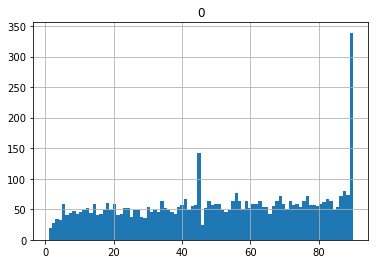

In [64]:
pd.DataFrame(np.hstack(match.time_elapsed.values)).hist(bins=90)

On observe beaucoup plus de buts à la 45ème et à la 90ème minutes ! En effet, les buts marqués pendants le temps additionel (91, 92, 93ème minutes) sont compté comme 90. Idem pour 45.

Etudions la position (distance + angle en degré) des tirs :

In [68]:
def extract_position_distance(row):
    if(not pd.isnull(row)):
        tree = html.fromstring(row)
        coord = tree.xpath('//coordinates/value/text()')
        return np.array(coord[0:][::2], dtype=np.int32)
    return np.nan

def extract_position_angle(row):
    if(not pd.isnull(row)):
        tree = html.fromstring(row)
        coord = tree.xpath('//coordinates/value/text()')
        return np.array(coord[1:][::2], dtype=np.int32)
    return np.nan

match['position_distance'] = match.goal.apply(lambda row: extract_position_distance(row))
match['position_angle'] = match.goal.apply(lambda row: extract_position_angle(row))

In [99]:
heatmap = pd.DataFrame([np.hstack(match.position_distance.values),np.hstack(match.position_angle.values)]).T
heatmap.dropna(inplace=True)
heatmap.columns = ['Distance', 'Angle']

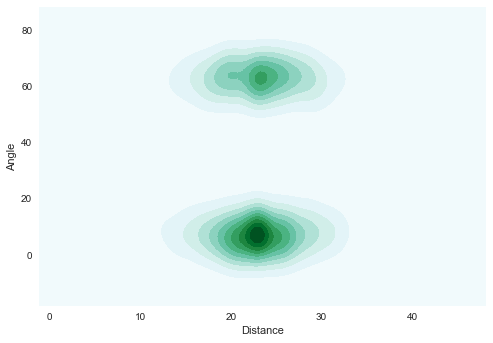

In [105]:
import seaborn
seaborn.kdeplot(heatmap.Distance, heatmap.Angle, shade=True)

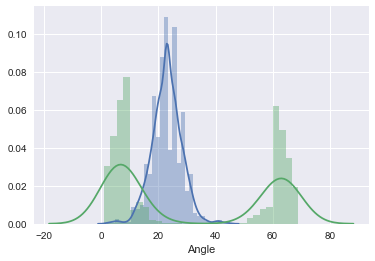

In [230]:
seaborn.distplot(heatmap.Distance, bins=30)
seaborn.distplot(heatmap.Angle, bins=30)

On va déterminer les tirs qui ont donné l'avantage

On extrait le nombre de tirs cadrés

In [181]:
def extract_nb_tirs(row):
    if(not pd.isnull(row)):
        tree = html.fromstring(row)
        equipe = tree.xpath('//team/text()')
        return np.array(equipe, dtype=np.int32)
    return []

match['tirs_cadres'] = match.shoton.apply(lambda row: extract_nb_tirs(row))
match['tirs_non_cadres'] = match.shotoff.apply(lambda row: extract_nb_tirs(row))

Maintenant qu'on a récupéré l'équipe qui a fait un tir, on va les sommer match par match et équipe par équipe

In [182]:
def agrege_equipe_cadres(row, home=True):
    if(len(row.tirs_cadres) > 0):
        if home:
            return (row.tirs_cadres == row.home_team_api_id).sum()
        else:
            return (row.tirs_cadres == row.away_team_api_id).sum()
    return 0

def agrege_equipe_non_cadres(row, home=True):
    if(len(row.tirs_non_cadres) > 0):
        if home:
            return (row.tirs_non_cadres == row.home_team_api_id).sum()
        else:
            return (row.tirs_non_cadres == row.away_team_api_id).sum()
    return 0
    
match['home_tir_cadre'] = match.apply(agrege_equipe_cadres, axis=1)
match['away_tir_cadre'] = match.apply(agrege_equipe_cadres, axis=1, home=False)
match['home_tir_non_cadre'] = match.apply(agrege_equipe_non_cadres, axis=1)
match['away_tir_non_cadre'] = match.apply(agrege_equipe_non_cadres, axis=1, home=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000017B96E48>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000002A3570B8>]], dtype=object)

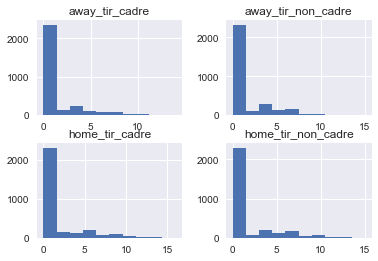

In [183]:
match[['home_tir_cadre','away_tir_cadre','home_tir_non_cadre','away_tir_non_cadre']].hist()

On remarque un problème : certaines lignes n'avaient pas l'information sur les tirs (non) cadrés. Il existe donc des lignes où le nombre de buts est différent de 0, mais où il n'y a pas l'information sur le nombre de tirs (non) cadrés. On va donc estimer le nombre de tirs cadrés en faisant nb_de_buts * coeff où coeff représente en moyenne combien de tirs cadrés il faut par but

In [184]:
match[match.home_tir_cadre ==0].home_team_goal.head(10)

4768    2
4769    2
4770    0
4773    0
4774    0
4775    3
4776    3
4779    1
4780    3
4783    2
Name: home_team_goal, dtype: int64

In [185]:
print(match[match.home_tir_cadre!=0].home_team_goal.sum()/float(match[match.home_tir_cadre!=0].home_tir_cadre.sum()))
print(match[match.home_tir_non_cadre!=0].home_team_goal.sum()/float(match[match.home_tir_non_cadre!=0].home_tir_non_cadre.sum()))

0.257081132981
0.24855891169


In [186]:
print(match[match.away_tir_cadre!=0].away_team_goal.sum()/float(match[match.away_tir_cadre!=0].away_tir_cadre.sum()))
print(match[match.away_tir_non_cadre!=0].away_team_goal.sum()/float(match[match.away_tir_non_cadre!=0].away_tir_non_cadre.sum()))

0.249922576649
0.23756582797


On va donc considérer les coefficients suivants :

In [187]:
def adjust_cadre(row, home=True):
    if home:
        if row.home_tir_cadre == 0 and row.home_team_goal != 0:
            return row.home_team_goal * 4
        return row.home_tir_cadre
    else:
        if row.away_tir_cadre == 0 and row.away_team_goal != 0:
            return row.away_team_goal * 4
        return row.away_tir_cadre
    
match['home_tir_cadre'] = match.apply(adjust_cadre, axis=1)
match['away_tir_cadre'] = match.apply(adjust_cadre, axis=1, home=False)

On a maintenant des distributions plus vraisemblables du nombre de tirs cadrés

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000038FFCF60>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000003977C240>]], dtype=object)

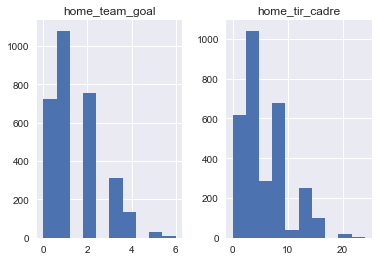

In [188]:
match[['home_team_goal','home_tir_cadre']].hist()

On va maintenant filtrer sur les lignes qui possèdent les informations supplémentaires sur les tirs, les fautes, les corners, etc.

In [ ]:
match.dropna(inplace=True)

match = match[(match.goal.str.startswith('<'))]
match = match[(match.shoton.str.startswith('<'))]
match = match[(match.shotoff.str.startswith('<'))]
match = match[(match.foulcommit.str.startswith('<'))]
match = match[(match.card.str.startswith('<'))]
match = match[(match.cross.str.startswith('<'))]
match = match[(match.corner.str.startswith('<'))]
match = match[(match.possession.str.startswith('<'))]

match.head()

In [ ]:
match

On va maintenant se limiter à la ligue 1 française dans un premier temps

In [189]:
match_ligue_1 = match[match.league_id == 4769]
num_teams = len(match_ligue_1.away_team_api_id.unique())
print(num_teams)

35


In [190]:
match.drop(['goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession'],
           axis=1, inplace=True)

## Construction du modèle

Maintenant que les données sont propres et identifiées, on va construire le modèle pymc3. Pour cela, il faut changer les noms des équipes en indices allant de 1 au nombre total d'équipe

In [191]:
teams = match_ligue_1.home_team_long_name.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

In [192]:
teams

,team,i
0,AJ Auxerre,0
1,Girondins de Bordeaux,1
2,Le Havre AC,2
3,Le Mans FC,3
4,Olympique Lyonnais,4
5,AS Monaco,5
6,AS Nancy-Lorraine,6
7,Stade Rennais FC,7
8,FC Sochaux-Montbéliard,8
9,Valenciennes FC,9


In [193]:
match_ligue_1 = pd.merge(match_ligue_1, teams, left_on='home_team_long_name', right_on='team', how='left')
match_ligue_1 = match_ligue_1.rename(columns = {'i': 'i_home'}).drop('team', 1)
match_ligue_1 = pd.merge(match_ligue_1, teams, left_on='away_team_long_name', right_on='team', how='left')
match_ligue_1 = match_ligue_1.rename(columns = {'i': 'i_away'}).drop('team', 1)

In [194]:
match_ligue_1.head()

,id,league_id,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,goal,shoton,shotoff,...,home_score_dynamique,away_score_dynamique,tirs_cadres,tirs_non_cadres,home_tir_cadre,away_tir_cadre,home_tir_non_cadre,away_tir_non_cadre,i_home,i_away
0,4769,4769,2008-08-09,8583,9830,2,1,NaN,NaN,NaN,...,0.000000e+00,0.0,[],[],8,4,0,0,0,30
1,4990,4769,2008-08-24,9827,9830,2,0,NaN,NaN,NaN,...,-2.000000e-01,-0.8,[],[],8,0,0,0,1,30
2,6710,4769,2013-11-10,9827,9830,0,3,<goal><value><comment>n</comment><stats><goals...,<shoton />,<shotoff />,...,1.200000e+00,0.4,[],[],0,12,0,0,1,30
3,7339,4769,2015-05-09,9827,9830,2,1,<goal><value><comment>p</comment><stats><penal...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,...,1.110223e-16,0.2,"[9830, 9827, 9827, 9827, 9830, 9830]","[9827, 9830, 9827, 9827, 9827, 9830]",3,3,4,2,1,30
4,7750,4769,2015-08-30,9827,9830,2,0,<goal><value><comment>npm</comment><event_inci...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,...,4.000000e-01,1.2,"[9830, 9827, 9827, 9830, 9827, 9830, 9827, 982...","[9830, 9827, 9830, 9830, 9830, 9827, 9827, 983...",7,5,7,5,1,30


On split notre jeu de données (60/20/20) afin de pouvoir mesurer plus tard les perfomances des différents modèles testés. NB : on fait exprès de ne pas randomiser les individus qui iront en train/CV/test. En effet, les observations sont ordonnées dans le temps, et en application réelle, on a accès uniquement au passé pour prédire le futur.

In [231]:
# On compte le nombre d'observations dont on dispose
taille_totale = len(match_ligue_1.home_team_goal.values)
# on calcule le nombre d'observations que l'on envoie en training set
train_size = int(taille_totale*0.6)
CV_size = int(taille_totale*0.8)

observed_home_goals = match_ligue_1.home_tir_cadre.values[:train_size]/float(4)
observed_away_goals = match_ligue_1.away_tir_cadre.values[:train_size]/float(4)

home_team = match_ligue_1.i_home.values[:train_size]
away_team = match_ligue_1.i_away.values[:train_size]

home_recuperation = np.array(match_ligue_1.recuperation_home.values[:train_size], dtype=np.float64)
away_recuperation = np.array(match_ligue_1.recuperation_away.values[:train_size], dtype=np.float64)

home_dynamique = np.array(match_ligue_1.home_score_dynamique.values[:train_size], dtype=np.float64)
away_dynamique = np.array(match_ligue_1.away_score_dynamique.values[:train_size], dtype=np.float64)

On décrit notre modélisation. On commence par spécifier les entrées et sorties de notre modélisation ![title](illustrations/V1.png)

In [232]:
import theano
import numpy as np

model_input_team = theano.shared(np.array([home_team, away_team]))
model_input_conditions = theano.shared(np.array([home_recuperation, away_recuperation, home_dynamique, away_dynamique]))
model_output = theano.shared(np.array([observed_home_goals, observed_away_goals]))

Puis on écrit le modèle

In [233]:
import pymc3 as pm

model = pm.Model()
with pm.Model() as model:
    # Paramètres spécifiques à chaque équipe  
    attaque = pm.Normal("attaque", mu=0, sd=1, shape=num_teams)
    defense = pm.Normal("defense", mu=0, sd=1, shape=num_teams)
    
    # Paramètre lié aux conditions du match
    coeff_home = pm.Normal("coeff_home", mu=0, sd=1, shape=1)
    coeff_recup = pm.Normal("coeff_recup", mu=0, sd=1, shape=1)
    coeff_dynamique = pm.Normal("coeff_dynamique", mu=0, sd=1, shape=1)
    
    # et un intercept
    intercept = pm.Normal("intercept", mu=0, sd=1, shape=1)
    
    home_theta  = pm.math.exp(intercept + 
                              coeff_home + 
                              coeff_recup * (model_input_conditions[0] - model_input_conditions[1]) + 
                              coeff_dynamique * (model_input_conditions[2] - model_input_conditions[3]) +
                              attaque[model_input_team[0]] - defense[model_input_team[1]] +
                              attaque[model_input_team[0]] * defense[model_input_team[1]]
                             )
    away_theta  = pm.math.exp(intercept + 
                              coeff_recup * (model_input_conditions[1] - model_input_conditions[0]) +
                              coeff_dynamique * (model_input_conditions[3] - model_input_conditions[2]) +
                              attaque[model_input_team[1]] - defense[model_input_team[0]] +
                              attaque[model_input_team[1]] * defense[model_input_team[0]]
                             )

    # likelihood of observed data 
    home_points = pm.Poisson('home_points', mu=home_theta, observed=model_output[0])
    away_points = pm.Poisson('away_points', mu=away_theta, observed=model_output[1])

In [ ]:
with model:
    trace = pm.sample(100, n_init=10000)

    pm.traceplot(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -5,763.8: 100%|██████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 481.49it/s]
Finished [100%]: Average ELBO = -5,469.3


La phase de sampling étant terminé, on va afficher pour chaque équipe la ditribution à posteriori des paramètres d'attaque et de défense sous forme de forestplot : 

In [ ]:
pm.forestplot(trace[10:], varnames=['attaque'], ylabels=teams.values, main="Team Offense", chain_spacing=0.2)

In [ ]:
pm.forestplot(trace[10:], varnames=['defense'], ylabels=teams.values, main="Team Defense", chain_spacing=0.2)

Les résultats semblent cohérents (le trio de tête est PSG - OL - OM), passons à la prédiction d'un nouveau match.

# Prédiction de l'issue d'un match

On cherche à prédire l'issue d'un match. Pour cela, on change les paramètres d'entrée, et on relance notre modèle : (ici : PSG contre Grenoble (indice 18 vs indice 17), on s'attend à voir le PSG gagner..

In [ ]:
model_input_team.set_value(np.array([[18],[17]]))
model_input_conditions.set_value([[1],[7],[2],[-2]])

Et on sample depuis notre modèle avec les nouvelles entrées

In [ ]:
ppc = pm.sample_ppc(trace[10:], model=model, samples=100)

On fait un peu de mise en forme des résultats afin de pouvoir les exploiter simplement

In [ ]:
away = pd.DataFrame(ppc['away_points'])
home = pd.DataFrame(ppc['home_points'])  

prediction_score = home.merge(away, how='inner', left_index=True, right_index=True)
prediction_score.columns = ['home_points', 'away_points']

In [ ]:
prediction_score.head()

In [ ]:
def vainqueur(row):
    if row[0] > row[1]:
        return 'H'
    elif row[0] < row[1]:
        return 'A'
    else:
        return 'N'

prediction_score['vainqueur'] = prediction_score.apply(vainqueur, axis=1)

In [ ]:
prediction_score.head()

In [ ]:
prediction_score.vainqueur.value_counts()

On calcule les probabilités associées

In [ ]:
100 * prediction_score.vainqueur.value_counts() / prediction_score.vainqueur.count()

Le PSG (home ici) a 77.9% de chances de l'emporter. 

On va enfin calculer le résultat le plus probable (les buts encaissés pour chacune des équipes). Une rapide visualisation nous montre que le résultat le plus probable est 2-0. Vérifions le :

In [ ]:
import seaborn
seaborn.kdeplot(data=prediction_score.home_points, data2=prediction_score.away_points, shade=True)

In [ ]:
prediction_score.groupby(["home_points", "away_points"]).size()

In [ ]:
prediction_score.groupby(["home_points", "away_points"]).size().idxmax()

In [ ]:
100. * prediction_score.groupby(["home_points", "away_points"]).size().max() / prediction_score.vainqueur.count()

Conclusion, le résultat est cohérent, on s'attend à ce que le PSG l'emporte (77.9% de chances) avec un score de 2-0 (17.4 % de chances)

# Evaluation des perfomances du modèle

Maintenant que l'on a vu que notre modèle est fonctionnel (et cohérent !), nous allons dans cette dernière section évaluer notre modèle. On commence par récupérer les données de cross-validation :

In [ ]:
observed_home_goals = match_ligue_1.home_tir_cadre.values[train_size+1:CV_size]/float(4)
observed_away_goals = match_ligue_1.away_tir_cadre.values[train_size+1:CV_size]/float(4)

home_team = match_ligue_1.i_home.values[train_size+1:CV_size]
away_team = match_ligue_1.i_away.values[train_size+1:CV_size]

home_recuperation = np.array(match_ligue_1.recuperation_home.values[train_size+1:CV_size], dtype=np.float64)
away_recuperation = np.array(match_ligue_1.recuperation_away.values[train_size+1:CV_size], dtype=np.float64)

home_dynamique = np.array(match_ligue_1.home_score_dynamique.values[train_size+1:CV_size], dtype=np.float64)
away_dynamique = np.array(match_ligue_1.away_score_dynamique.values[train_size+1:CV_size], dtype=np.float64)

Et on assigne ces nouveaux individus comme entrée et sortie de notre modèle

In [ ]:
model_input_team.set_value(np.array([home_team,away_team], dtype=np.int32))
model_input_conditions.set_value(np.array([home_recuperation,away_recuperation,home_dynamique,away_dynamique], dtype=np.float64))

Et on tire 10000 réalisations pour chacun des matchs

In [ ]:
ppc = pm.sample_ppc(trace[10:], model=model, samples=100)

L'échantillon est désormais créer, on va maintenant comparer nos prédictions avec la réalité :

In [ ]:
away_prediction = pd.DataFrame(ppc['away_points'])
home_prediction = pd.DataFrame(ppc['home_points'])  

On crée un dataframe pour chaque match (chacun contenant 10000 simulations)

In [ ]:
prediction_score = [home_prediction[[i]].merge(away_prediction[[i]], 
                                               how='inner', 
                                               left_index=True, right_index=True) 
                    for i in range(len(home_team))]

for df in prediction_score:
    df.columns = ['home_prediction', 'away_prediction']

Pour chaque dataframe, on détermine l'équipe qui gagne

In [ ]:
def vainqueur(row):
    if row[0] > row[1]:
        return 'H'
    elif row[0] < row[1]:
        return 'A'
    else:
        return 'N'

In [ ]:
for df in prediction_score:
    df['prediction_vainqueur'] = df.apply(vainqueur, axis=1) 

On ajoute aussi le score le plus probable d'après nos simulations :

In [ ]:
resultats = list()
    
for df in prediction_score:
    home_score, away_score = df.groupby(["home_prediction", "away_prediction"]).size().idxmax()
    resultats.append(
        [df.prediction_vainqueur.value_counts().idxmax(), home_score, away_score]
    )
    
resultats = pd.DataFrame(np.array(resultats))
resultats.columns = ['prediction_vainqueur', 'prediction_home_score', 'prediction_away_score']

#on remet les scores au type int, sinon il sont converti en 'objet' ...
resultats[['prediction_home_score', 'prediction_away_score']] = resultats[['prediction_home_score', 'prediction_away_score']].astype(np.int32)

On met en forme aussi les vrais résultats (ie. les observations)

In [ ]:
vrai_home = pd.DataFrame(observed_home_goals)
vrai_away = pd.DataFrame(observed_away_goals)  

In [ ]:
vrai_resultats = vrai_home.merge(vrai_away, how='inner', left_index=True, right_index=True)
vrai_resultats.columns = ['home_points', 'away_points']

vrai_resultats['vainqueur'] = vrai_resultats.apply(vainqueur, axis=1)

vrai_resultats = vrai_resultats.merge(resultats, how='inner', left_index=True, right_index=True)

On a enfin notre dataframe contenant les observations et les prédictions (gagnant + score) match par match :

In [ ]:
vrai_resultats

On calcule notre score :

In [ ]:
from sklearn import metrics

metrics.accuracy_score(vrai_resultats.vainqueur.values, vrai_resultats.prediction_vainqueur.values)

Ce n'est pas si mal pour un premier modèle, extrèmement simple pour le moment... Cherchons à identifier quels matchs sont mal classifiés :

In [ ]:
#Code repris entièrement des exemples scikit-learn

import itertools
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

class_names = ['A','H','N']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(vrai_resultats.vainqueur.values, vrai_resultats.prediction_vainqueur.values)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

Commentaires :
- Les résultats sont encourageant pour un modèle aussi simple (quasiment 50% de réussite, à comparer aux 33% d'une méthode complètement aléatoire)
- On prédit trop souvent Away : peut être que le modèle favorise trop l'équipe à domicile...

In [ ]:
vrai_resultats.vainqueur.value_counts() / vrai_resultats.vainqueur.count()

prochaine étapes :
- améliorer le modèle hierarchique (prendre en compte les tirs cadrés, etc.)
- modéliser au niveau de chaque joueur ?
- écrire le code d'une simulation d'une saison entière pour obtenir le classement final

Enfin, on va compter le nombre de fois où notre projection de score est correcte

In [ ]:
score_juste = vrai_resultats[vrai_resultats.home_points == vrai_resultats.prediction_home_score]
score_juste = score_juste[vrai_resultats.away_points == vrai_resultats.prediction_away_score]
len(score_juste) / float(len(vrai_resultats))

On a prédit le bon score dans 14.5% des cas.

Par la suite, on améliorera le modèle selon 3 axes :
- les buts étant des évênements rares, ils sont soumis à une grande variabilité et peuvent donc être une métrique trompeuse. Il va donc falloir "l'augmenter" avec d'autres évênements moins rares, mais quasiment tout autant important : le nombre de tirs cadrés, non cadrés, corner, de pénaltis, etc.
- mieux charactériser les paramètres latents d'une équipe. On a ici résumé l'information disponible à un score d'attaque et un score de défense, mais il y en a certainement d'autres : la possession moyenne de balle par exemple ? ...
- mieux charactériser la situation du match, indépendement des performances d'une équipe : le fait de jouer à domicile a été pris en compte ici, mais on peut penser à d'autres choses, tels que le temps de repos depuis le dernier match, etc.
- prendre en compte l'évolution du style de jeu au cours des années (cf le notebook sur les buts vs loi de poisson)

Eventuellement plus tard modéliser au niveau du joueur